# Blackjack 

We consider a slightly simplified version of **blackjack** in which a **player** plays against the **dealer**. Both agents (**player** and **dealer**) start with a single card. The **player** first take his turns, and then (once the player is finished) the **dealer** may play (unless the player was _busted_, in which case the dealer authomatically wins, and need not play).

In each turn, an agent may choose two actions: **HIT** or **HOLD**. By choosing **HIT**, the agent is asking for one more card from the deck. By choosing **HOLD**, the agent finishes his turn without drawing an additional card.

The agent **total** is the sum of **values** of all cards the agent has drawn, including the initial card handed to it on the start of the game. The "small cards" (2, 3, 4, ..., 9, 10) have the value equal to their number. The "face cards" (J, Q, K) have value 10. Ace (A) can have two values: 1 or 11, depending on the choice of the agent.

THE GOAL OF THE GAME IS TO HAVE THE HIGHEST TOTAL NOT BIGGER THAN 21. If an agent achieves the total bigger than 21 it losses the game (we say that the agent is _busted_ in this case). More precisely:

* If the player is busted, dealer wins.
* If the players is not busted, then:
  - If the dealer is busted, player wins.
  - If the dealer is not busted, the agent with the highest total wins.
  - In case that neither agent is busted, and both have the same total, the game is draw.
 
Upon playing each game, the wining agent receives reward +1, the losing agent receives -1. If the game is draw, both agents receive 0. The reward is given only when the game is over. No reward is received after non-terminating actions (the reward following those actions is 0).

<div class="alert alert-block alert-info">
<b>The Assignment:</b> 
Train a bot able to play blackjack agains the dealer.
</div>

<div class="alert alert-block alert-warning">
<b>Dealer strategy:</b> 
    Assume that the dealer is playing according to a fixed strategy: Choose HIT as long as the dealer total is not above 17, otherwise choose HOLD.
</div>

## Basic Imports

In [1]:
from enum import Enum
from dataclasses import dataclass, astuple
from typing import Callable
from random import random, randint
from copy import deepcopy

from tqdm import trange
from rich import print

import numpy as np
import matplotlib.pyplot as plt

## Cards and Decks of Cards

Let us first implement cards and decks of cards.

In [2]:
class CardSuit(Enum):
    """An enumeration representing card suits."""
    
    DIAMONDS = 0
    CLUBS = 1
    HEARTS = 2
    SPADES = 3

    def __repr__(self):
        match self:
            case CardSuit.DIAMONDS:
                return "♦"
            case CardSuit.CLUBS:
                return "♣"
            case CardSuit.HEARTS:
                return "♥"
            case CardSuit.SPADES:
                return "♠"

In [3]:
class CardValue(Enum):
    """An enumeration representing card values."""

    ACE = 1
    TWO = 2
    THREE = 3
    FOUR = 4
    FIVE = 5
    SIX = 6
    SEVEN = 7
    EIGHT = 8
    NINE = 9
    TEN = 10
    JACK = 12
    DAME = 13
    KING = 14

    def __repr__(self):
        if self == CardValue.ACE:
            return "A"
        elif self.value >= 2 and self.value <= 10:
            return str(self.value)
        elif self == CardValue.JACK:
            return "J"
        elif self == CardValue.DAME:
            return "D"
        elif self == CardValue.KING:
            return "K"

A card is completely defined by a combination of face and suit. We could implement cards as tuples. However, we will implement a separate class for this, solely in order to have a nice, natural representation of cards as string.

To get the best of both worlds, we will create a card class a _dataclass_!

In [4]:
@dataclass
class Card:
    """A playing card."""
    value: CardValue
    suit: CardSuit

    def __repr__(self):
        return f"{repr(self.value)}{repr(self.suit)}"

Just to illustrate, let us create a card and see how nicely it is written to the console.

In [5]:
Card(value=CardValue.ACE, suit=CardSuit.HEARTS)

A♥

Once we have implemented individual cards, we may proceede to implement a deck.

In [6]:
class CardDeck:
    """A deck of cards.

    The deck contains 52 playing cards, which are shuffled and drawn consecutively.
    Once all cards have been drawn, the deck reshuffles automatically.
    """

    def reshuffle(self):
        """Refill the deck with all playing cards and reshuffle it."""
        self.cards = self.multiplicity * [Card(value=v, suit=s) 
                                          for v in iter(CardValue) 
                                          for s in iter(CardSuit)]
        np.random.shuffle(self.cards) 

    def __init__(self, multiplicity=5):
        """Create a shuffled deck of cards.
        
        Args:
            multiplicity (int): The number of 52-card sets to put inside a deck.
        """
        self.multiplicity = multiplicity
        self.reshuffle()

    def draw(self):
        """Draw a card from the deck.

        Once drawn, the card is removed from the deck. Once there are no more cards inside,
        the deck will automatically refill and reshuffle.
        """
        if not self.cards:
            self.reshuffle()
        return self.cards.pop(0)

In [7]:
# These few lines simply visualize random card ordering in a deck.
deck = CardDeck()
print(", ".join([repr(c) for c in deck.cards]))

A♦, D♣, A♦, J♠, A♣, 4♠, D♥, 6♠, 7♦, D♠, 5♦, K♠, 10♥, J♥, 9♥, K♥, 4♥, 9♦, 6♠, 7♥, 10♠, 3♣, 4♦, D♥, D♦, 4♣, K♣, 10♣, 
2♠, 2♠, D♦, 10♣, 5♠, 9♦, 2♦, 5♣, 6♠, 9♣, J♣, 8♥, K♠, 8♥, K♣, 4♠, 10♥, 3♣, 2♣, 7♠, 10♠, 3♠, 8♥, 6♥, 7♦, D♣, 5♦, 7♣, 
7♠, 3♠, A♥, 2♠, 8♠, 3♦, J♣, 8♣, J♦, 6♣, 2♣, 8♦, 5♦, 8♣, 3♦, 3♣, 2♥, 4♦, 10♦, 7♣, 5♣, D♦, 3♥, 8♣, 5♠, 10♥, 4♠, J♣, 
A♠, 8♥, J♦, J♣, 8♦, 9♥, 9♣, A♣, 8♠, A♦, 5♥, 5♥, 9♣, 7♠, J♠, 7♥, 8♦, D♥, D♦, J♦, 5♣, D♥, 7♥, 9♠, 6♥, 5♦, 2♦, 10♠, 
9♠, J♦, A♠, J♥, 10♠, 4♥, 8♣, D♠, 6♦, J♣, D♣, D♦, 5♠, 6♠, 5♦, 10♦, K♥, 10♣, J♦, 9♦, 9♥, J♥, K♦, 9♠, 6♣, 9♣, 7♣, 4♣, 
4♦, 9♥, 8♠, 5♣, J♠, 7♥, 7♠, A♣, 10♥, D♠, A♦, 3♥, D♠, J♥, D♠, 4♣, 2♠, 2♣, 5♠, 5♠, 8♣, 4♠, K♣, 8♦, 10♦, 2♥, 3♣, 7♠, 
A♠, 3♠, 6♦, 9♠, K♠, A♠, K♦, 6♦, 3♦, 2♦, K♠, A♣, 6♥, 2♦, 7♦, A♦, 7♦, 4♦, 10♦, 6♦, A♥, 9♦, A♥, 10♦, 6♦, 10♥, K♥, 9♣, 
5♥, A♠, 8♠, K♦, 3♦, 9♠, 6♥, 10♠, 2♥, K♦, K♦, 10♣, 8♠, 8♥, 2♥, 4♥, 7♣, K♥, K♣, 5♣, 3♥, A♥, 3♣, K♥, 4♥, 2♥, 3♥, 2♦, 
6♣, 4♠, D♣, 2♠, 2♣, J♥, 4♥, 5♥, 4♦, J♠, 3♠, A♣, 3♠, K♣, 3♦, K♠, 6♣, 2♣, 4♣, 7♦, D♥, 7♣, 7♥, 4♣, 6♣, 6♥, D♣, 10♣, 
9♦, A♥, J♠, 9♥, 8♦, 6♠, 3♥, 5♥

## Blackjack State and Rules for Updating the State

We now proceede to implement the state of a blackjack game, as well as different policies.

From the position of a player, the **state** of a blackjack game is defined by the list of all cards it has previously drawn (including the card that was initially given to it) and also the card in the posession of the dealer. However, the state defined in such a way actually contains more information than is needed to form a decission. It is sufficient to know:
* the current player total;
* if this total is created using an ACE which can be converted to 1, if needed; and
* the value of the dealer's card

As before, we utilize the concept of `dataclass` in order to implement the `State`.

In [8]:
@dataclass
class State:
    """The state of a Blackjack game"""
    total: int
    has_ace: bool
    dealer_total: int

    def __hash__(self):
        return hash(astuple(self))

    def __repr__(self):
        return repr(astuple(self))

We will now define a function which updates the total once the new card is drawn. In a way, this function implements core of the blackjack playing rules.

In [9]:
def update_total(total: int, has_ace: bool, card_value: CardValue) -> tuple[int, bool]:
    """Update (a portion of) the player state by taking account a newly drawn card.
    
    Given the information regarding the current player state (total and ACE info), and the
    value of a newly drawn card, updates the current player state (both total and ACE info).

    The updated total returned by this function can be bigger than 21.
    The function correctly tracks statuses of ACEs (i.e. it changes values of ACEs from
    11 to 1, when appropriate, in order for the total not to excede 21), however, if
    after this the total still remains bigger than 21 the function will simply return it
    as is.

    Args:
        total (int): player total
        has_ace (bool): indicates if the player has usable ACE
        card_value (CardValue): value of the newly drawn card

    Returns:
        int: updated player total
        bool: updated info indicating if the player has a usable ACE
    """
    if card_value == CardValue.ACE:
        if total + 11 <= 21:
            # We have an ACE and the total is less than 21.
            # We can keep the ACE as 11.
            # Notice that it was impossible that we had another ACE in posession
            # before (since in that case the total would surely be bigger than 21)
            return (total+11, True)
        else:
            # The total excedes 21, and we must count the ACE as 1.
            # It is possible we had another active ACE before, if so the
            # status of this old ACE does not change.
            return (total+1, has_ace)
    else:
        total += min(card_value.value, 10)
        if total > 21:
            # The player is potentially busted.
            if has_ace:
                # If we have an active ACE, we are saved.
                # The ACE value is reduced from 11 to 1 (and the total is reduced by 10).
                # However, the cost is that we no longer have an active ACE.
                total -= 10
                return (total, False)
            else:
                # We have not active ACE, so we cannote decrease the total
                return (total, has_ace)
        # The total is less than 21, we may return the state as is.
        return (total, has_ace)

Another usefull function will be the one that generates a random state. A valid Blackjack state is any in which the player total is between 2 and 21 (1 is never the total, since it could only happen by having a single ACE, which would be counted by 11). ACE indication can be `True` only if the total is bigger or equal to 11. Further, since the dealer has only one card during a player's turn, possible card values are between 2 and 11. 

In [10]:
def random_state() -> State:
    """Generate a random state."""
    total = randint(2, 21)
    if total>= 11:
        r = random()
        if r >= 0.5:
            has_ace = True
        else:
            has_ace = False
    else:
        has_ace = False
    dealer_value = randint(2, 11)
    return State(total, has_ace, dealer_value)

In [11]:
def all_states() -> list[State]:
    """Create a list of all possible Blackjack states."""
    states = []
    for total in range(2, 22):
        for dealer_value in range(2, 12):
            states.append(State(total, False, dealer_value))
            if total >= 11:
                states.append(State(total, True, dealer_value))
    return states

In [12]:
states = all_states()
len(states)

310

## Blackjack Actions and Policies

We are now ready to define some interesting Blackjack policies. Before doing that, we will need to define Blackjack actions.

In [13]:
class Action(Enum):
    """Blackjack action."""
    HIT = 0
    HOLD = 1

    def __repr__(self):
        return "HIT" if self == Action.HIT else "HOLD"

In [14]:
def random_action() -> Action:
    """Return random action."""
    r = random()
    if r <= 0.5:
        return Action.HIT
    else:
        return Action.HOLD

A policy can be seen as a function which, given a state, returns the action to take. Let us first define a type to describe all actions (so that we can use it in signatures of functions and methods).

In [15]:
Policy = Callable[[State], Action]

Let us first define a **random policy**: A player using this policy will choose an action at random regardless of the state.

In [16]:
def random_policy(s: State) -> Action:
    return random_action()

Another interesting policy is the **delaer policy**: Choose HIT whenever the total is less than 17, otherwise play HOLD.

In [17]:
def dealer_policy(s: State) -> Action:
    total, has_ace, _ = astuple(s)
    if total < 17:
        return Action.HIT
    else:
        return Action.HOLD

## Using a Policy: Playing an Entire Turn (of a Player or a Dealer)

We now proceed to implement a single **turn**. This will be used to identify a sequence of HIT actions of a single agent, starting from some given initial state until a HOLD action is selected, or the total excedes 21. One Blackjack game (the way we are playing it here) consists of two turns: the player's turn and the dealer's turn. So, once we implement the turn, we will be able to implement a single game. A path to implementing a learning agent will then be completely set.

In general, we will be "playing" games in several different scenarios. In cases we are learning, we will be interested in "playing" many (thousands and tens of thousands) of games silently. In other cases, particularly during testing and demonstration, we will be interested in carefully tracing each event within a single game. 

Another interesting point to note is that we will wish to "play" games starting from different initial states. During learning, it will be of interest to choose the initial state completely randomly. During demonstration, it will be more interesting to have the game start in the usual way: by drawing a card from the deck for the player and another card from the deck for the dealer. For this reason, the `get_init_state` function allows for the `state` argument to be specified in three different ways:
* as a `State` object, in which case this object is returned as the initial state
* as a string "random", in which case a state is drawn completely randomly from the set of all possible states
* as `None`, in which case the initial state is generated in the same way the game is actually played (by drawing cards from the deck: one for the player and one for the dealer)

In [18]:
def get_init_state(state: State | str | None, deck: CardDeck) -> State:
    """Generate initial state."""
    if state is None:
        player_card = deck.draw()
        total, has_ace = update_total(0, False, player_card.value)
        dealer_card = deck.draw()
        dealer_value = min(dealer_card.value.value, 10)
        return State(total, has_ace, dealer_value)
    else:
        if isinstance(state, str):
            assert state == "random", f"Invalid init state specification: '{state}'"
            return random_state()
        else:
            return state

Similarly, we may wish to simulate a turn with a fixed given initial action, or with the initial action determined by the decision policy. The `action` parameter behaves in the same way as the `state` parameter in the `get_init_state` function: it can be an `Action` object, the string "random", or `None`. In this case:
* specifying an `Action` object results in returning the same object
* specifying "random" requests for a radnom action
* specifying `None` results in an action specified by the given decision policy

In [19]:
def get_init_action(action: Action | str | None, state: State, policy: Policy) -> Action:
    """Generate initial action."""
    if action is not None:
        if isinstance(action, str):
            assert action == "random", f"Ivalid init action specification: '{action}'"
            return random_action()
        else:
            return action
    else:
        return policy(state)

Finally, we are ready to implement a single turn of play... While playing we will track (log) the sequence of states and actions (we will refer to a list of all state-action pairs as `TurnLog`). We will need those information later, while implementing learning agents.

To make reporting functionality flexibile, we will add optional reporting arguments to all "turn-playing" and "game-playing" functions we implement -- report callbacks. They will be functions which take a textual message and (optionally) report them to a user.

In [20]:
TurnLog = list[tuple[State, Action]]
ReportCallback = Callable[[str], None]

Now, we implement the function which actually plays a single turn of an agent (which may be a player or a dealer).

In [21]:
def play_turn(policy: Policy, 
              deck: CardDeck, 
              init_state: State | None = None,
              init_action: Action | None = None, 
              report_callback: ReportCallback | None = None) -> tuple[int | None, TurnLog]:
    """A single playing turn of an agent.

    Args:
        policy (Policy): decision policy used by the agent
        deck (CardDeck): deck of cards from which to draw
        init_state (State | None): initial state or `None` if the initial state
                                   is to be selected by drawing from the deck.
        init_action (Action | None): initial action or `None` if the initial action
                                     is to be selected according to the decision policy
        report_callback (ReportCallback | None): callback used to report progress
                                                 if `None`, the turn will be played silently

    Return:
        int | None: The final agent's total or `None` if the agent is busted
        TurnLog: sequence of states and actions observed during gameplay
    """
    report = lambda txt: report_callback and report_callback(txt)
    state = get_init_state(init_state, deck)
    action = get_init_action(init_action, state, policy)
    total, has_ace, dealer_value = astuple(state)
    report(f"[bold]initial state[/] {state}")
    report(f"initial total {total} with ACE {has_ace} => [bold]initial action[/] {action}")
    turn_log = [(state, action)]
    while action == Action.HIT:
        card = deck.draw()
        total, has_ace = update_total(total, has_ace, card.value)
        state = State(total, has_ace, dealer_value)
        if total > 21:
            # Since total is above 21, the state is not valid and should not
            # be logged!
            report(f"turned finished - [bold]BUSTED![/] card drawn {card} => total {total} with ACE {has_ace}")
            return None, turn_log
        else:
            action = policy(state)
            turn_log.append((state, action))
            report(f"card drawn {card} => total {total} with ACE {has_ace} => action chosen {action}")
    report(f"turn finished with final total {total}")
    return total, turn_log

We can now test the functionality implemented thus far... We will first create a small callback function useful for reporting. Please note that this function is using `print` function **which is not the default `print` function of `python`**. In the very first cell of this notebook there is a line:

```
from rich import print
```

This line introduces the `print` function from the `rich` library and essentially overloads the name `print`, so that any subsequent call to `print` actually reference the implementation from the library and not the built-in one. One of the advantages of the `rich` version of the `print` function is that it can produce rich and colorfull output using simple and straightforward markup language.

In [22]:
report_callback = lambda txt: print(f"[bold blue]AGENT:[/] {txt}")

In [23]:
# Testing the random policy
# Initial state is chosen by drawing cards from the deck. The initial action is chosen according to the policy
play_turn(random_policy, deck, report_callback=report_callback)

AGENT: initial state (11, True, 10)

AGENT: initial total 11 with ACE True => initial action Action.HOLD

AGENT: turn finished with final total 11

(11, [((11, True, 10), HOLD)])

In [24]:
# Testing the dealer's policy
# Initial state is chosen by drawing cards from the deck. The initial action is chosen according to the policy
play_turn(dealer_policy, deck, report_callback=report_callback)

AGENT: initial state (11, True, 10)

AGENT: initial total 11 with ACE True => initial action Action.HIT

AGENT: card drawn A♣ => total 12 with ACE True => action chosen Action.HIT

AGENT: card drawn 4♠ => total 16 with ACE True => action chosen Action.HIT

AGENT: card drawn D♥ => total 16 with ACE False => action chosen Action.HIT

AGENT: turned finished - BUSTED! card drawn 6♠ => total 22 with ACE False

(None,
 [((11, True, 10), HIT),
  ((12, True, 10), HIT),
  ((16, True, 10), HIT),
  ((16, False, 10), HIT)])

In [25]:
# If we like, we can force the initial action.
# Subsequent actions will be selected according to the given policy.
play_turn(dealer_policy, deck, init_action=Action.HOLD, report_callback=report_callback)

AGENT: initial state (7, False, 10)

AGENT: initial total 7 with ACE False => initial action Action.HOLD

AGENT: turn finished with final total 7

(7, [((7, False, 10), HOLD)])

In [26]:
# If we like, we may also require the initial state to be selected completely at random.
# As before, the initial action is selected according to the policy
play_turn(dealer_policy, deck, init_state="random", report_callback=report_callback)

AGENT: initial state (13, True, 10)

AGENT: initial total 13 with ACE True => initial action Action.HIT

AGENT: card drawn 5♦ => total 18 with ACE True => action chosen Action.HOLD

AGENT: turn finished with final total 18

(18, [((13, True, 10), HIT), ((18, True, 10), HOLD)])

In [27]:
# We can also force both the initial state and the initial action to be selected completely randomly
play_turn(dealer_policy, deck, init_state="random", init_action="random", report_callback=report_callback)

AGENT: initial state (21, True, 9)

AGENT: initial total 21 with ACE True => initial action Action.HIT

AGENT: card drawn K♠ => total 21 with ACE False => action chosen Action.HOLD

AGENT: turn finished with final total 21

(21, [((21, True, 9), HIT), ((21, False, 9), HOLD)])

## Using a Policy: Playing an Entire Game

We will now implement a function that will be used to play entire games. In addition to playing the game, the function will also collect experience - tripples containing states, actions, and the total discounted return (gain) - collected during play.

In [28]:
Experience = tuple[State, Action, float]

We will first a need some auxiliary functionality that computes discounted gains from rewards.

In [29]:
def compute_gain(rewards: list[float], gamma: float) -> float:
    """
    Compute the total gain given the list of future rewards.
    
    Args:
        rewards (list[float]): List of future rewards.
        gamma: discount factor

    Return:
        float: The total gain
    """
    g = 0
    w = 1
    for r in rewards:
        g += w*r
        w *= gamma
    return g

def discounted_gains(rewards: list[float], gamma) -> list[float]:
    """
    Compute list of discounted gains, given a sequence of rewards.

    Args:
        rewards (list[float]): Sequence of rewards.
        gamma: discount factor

    Return:
        list[float]: sequence of gains
    """
    gains = [compute_gain(rewards[i:], gamma) for i in range(len(rewards))]
    return gains

Let us first see how the above auxiliary functions work. When the discount factor is 1, the rewards given after the final move are copied to the preceding move without change.

In [30]:
rewards = [0, 0, 0, 1]
discounted_gains(rewards, 1.0)

[1.0, 1.0, 1.0, 1]

However, if the discount factor is lower, then the earlier moves (ones further away from the final one) are given less credit for the final result

In [31]:
discounted_gains(rewards, 0.9)

[0.7290000000000001, 0.81, 0.9, 1]

Now we need a function which builds experience from the state-action pairs encountered during a single turn.

In [32]:
def build_experience(turn_log: TurnLog, result: int, gamma) -> Experience:
    """
    Compute experience from the turn log (list of state-action pairs) and the final result.

    Args:
        turn_log (TurnLog): List of state-action pairs encountered during single gameplay
        result (int): Final result of the game.

    Return:
        Experience: List of state-action-gain triples corresponding to every state-action pair encountered during a game.
    """
    rewards = [0 for _ in turn_log]
    rewards[-1] = result
    gains = discounted_gains(rewards, gamma)
    exp = [(s, a, g) for (s, a), g in zip(turn_log, gains)]
    return exp

We are now ready to actually implement the function to play games... 

Note that we have three distinct callback functions: one for the player, one for the dealer, and one for the game engine itself. This may seem excessive, but it will enable us to nicely track what is going on within a single game!

In [33]:
def play_game(policy: Policy, 
              deck: CardDeck, 
              init_state: State | str | None = None,
              init_action: Action | str | None = None,
              gamma : float = 1.0,
              game_report_callback: ReportCallback | None = None,
              player_report_callback: ReportCallback | None = None,
              dealer_report_callback: ReportCallback | None = None) -> tuple[int, Experience]:
    """A single game of Blackjack, played with the given policy.
    
    Args:
        policy (Policy): the decision policy to use during gameplay
        init_state (State | str | None): specification of the initial state, see `get_init_state`
        init_action (Action | str | None): specification of the initial action, see `get_init_action`
        gamma (float): discount factor
        game_report_callback (ReportCallback | None): report callback used for the events generated by the game "engine"
        player_report_callback (ReportCallback | None): report callback used for the player actions
        dealer_report_callback (ReportCallback | None): report callback used for the dealer actions

    Return:
        int: The result of the game: +1 for win, 0 for draw, -1 for loss
        Experience: experience accumulated during the game 
    """
    report = lambda txt: game_report_callback and game_report_callback(txt)
    state = get_init_state(init_state, deck)
    action = get_init_action(init_action, state, policy)
    player_total, turn_log = play_turn(policy, deck, init_state=state, init_action=action, report_callback=player_report_callback)
    if player_total is not None:
        dealer_card = CardValue(state.dealer_total) if state.dealer_total != 11 else CardValue.ACE
        dealer_total, dealer_has_ace = update_total(0, False, dealer_card)
        dealer_state = State(dealer_total, dealer_has_ace, 0)
        dealer_total, _ = play_turn(dealer_policy, deck, init_state=dealer_state, report_callback=dealer_report_callback)
        if dealer_total is not None:
            if player_total > dealer_total:
                result = +1
            elif player_total == dealer_total:
                result = 0
            else:
                result = -1
        else:
            result = +1
    else:
        result = -1
    exp = build_experience(turn_log, result, gamma)
    if result == 1:
        report("Player WINS")
    elif result == 0:
        report("Game DRAW")
    else:
        report("Player LOSES")
    return result, exp

In order to test the last function, let us define some handy report callbacks. We will use prefixes and color-coding to nicely highlight reports from different "actors" (player, dealer, and the game "engine" itself).

In [34]:
player_report_callback = lambda txt: print(f"[bold blue]PLAYER:[/] {txt}")
dealer_report_callback = lambda txt: print(f"[bold cyan]DEALER:[/] {txt}")
game_report_callback = lambda txt: print(f"[bold red]{txt}[/]")

callbacks = {
    "player_report_callback": player_report_callback,
    "dealer_report_callback": dealer_report_callback,
    "game_report_callback": game_report_callback
}

Let us play a bit with the two above-defined policies. Later we will show that the dealer policy is considerably more meaningfull than the random one (as expected!)

Notice the manner in which the callback are passed to the `play_game` function. We first collect them into a dictionary where the keys are strings equal to the corresponding keyword parameter names of the `play_game` function. The values are the callback themselves. The syntax `**callbacks` (the leading `**`) "unpacks" this dictionary into sequence of key-value pairs which are given to the `play_game` function as named parameters.

In [35]:
# Playing the game using the random policy
play_game(random_policy, deck, **callbacks)

PLAYER: initial state (10, False, 10)

PLAYER: initial total 10 with ACE False => initial action Action.HIT

PLAYER: card drawn 9♥ => total 19 with ACE False => action chosen Action.HOLD

PLAYER: turn finished with final total 19

DEALER: initial state (10, False, 0)

DEALER: initial total 10 with ACE False => initial action Action.HIT

DEALER: card drawn K♥ => total 20 with ACE False => action chosen Action.HOLD

DEALER: turn finished with final total 20

Player LOSES

(-1, [((10, False, 10), HIT, -1.0), ((19, False, 10), HOLD, -1)])

In [36]:
# Playing the game using the dealer policy
play_game(dealer_policy, deck, **callbacks)

PLAYER: initial state (4, False, 9)

PLAYER: initial total 4 with ACE False => initial action Action.HIT

PLAYER: card drawn 6♠ => total 10 with ACE False => action chosen Action.HIT

PLAYER: card drawn 7♥ => total 17 with ACE False => action chosen Action.HOLD

PLAYER: turn finished with final total 17

DEALER: initial state (9, False, 0)

DEALER: initial total 9 with ACE False => initial action Action.HIT

DEALER: card drawn 10♠ => total 19 with ACE False => action chosen Action.HOLD

DEALER: turn finished with final total 19

Player LOSES

(-1,
 [((4, False, 9), HIT, -1.0),
  ((10, False, 9), HIT, -1.0),
  ((17, False, 9), HOLD, -1)])

Finally, let us define a function that will enable us to apply (and test) different policies. This function will play many games, collect experience and compute the ratio of wins, draws, and losses.

But first, we must define **experience** more precisely! Experience is a list of states, actions and gains seen during playtime. In otherwords, to each state-action pair seen in each turn we must associate the total gain received during that game from this point on (possibly discounted by a suitable discount factor - $\gamma$)

In [37]:
@dataclass
class PolicyTestingResult:
    games_no: int
    score: int
    wins: float
    draws: float
    losses: float

    def loss_per_game(self):
        """Average loss per game."""
        return self.score/self.games_no

    def __repr__(self):
        return f"total score={self.score}/{self.games_no} games ({self.loss_per_game():.4f} per game) :: W {self.wins*100:.2f}% | D {self.draws*100:.2f}% | L {self.losses*100:.2f}%"

We will make two different methods for evaluating policies. The first one chooses initial states and actions randomly in each run. The second one repeatedly enumerates through all possible states and all possible actions, and uses all possible combinations of the initial state-action pair. The enumerated version is possible only because the number of states in (this version of) Blackjack is not high.

In [38]:
def apply_policy(policy: Policy, deck: CardDeck, games_no=1000, gamma=1, random_init_state=False, random_init_action=False) -> tuple[PolicyTestingResult, Experience]:
    wins, losses, draws, score = 0, 0, 0, 0
    init_action = "random" if random_init_action else None
    init_state = "random" if random_init_state else None
    experience = []
    for k in range(games_no):
        res, exp = play_game(policy, deck, gamma=gamma, init_state=init_state, init_action=init_action)
        score += res
        experience.extend(exp)
        if res == 1:
            wins += 1
        elif res == 0:
            draws += 1
        else:
            losses += 1
    return PolicyTestingResult(games_no, score, wins/games_no, draws/games_no, losses/games_no), experience

Let us test the above function by playing just five games, to see what kind of objects it returns. The actual tests require many more games to be played, and this will be done shortly after...

In [39]:
res = apply_policy(random_policy, deck, 5, gamma=0.9)
print(res)

(
    total score=1/5 games (0.2000 per game) :: W 60.00% | D 0.00% | L 40.00%,
    [
        ((3, False, 4), HIT, -0.9),
        ((13, False, 4), HOLD, -1),
        ((10, False, 10), HOLD, 1),
        ((10, False, 5), HIT, 0.9),
        ((19, False, 5), HOLD, 1),
        ((9, False, 10), HIT, -0.9),
        ((17, False, 10), HIT, -1),
        ((8, False, 10), HOLD, 1)
    ]
)

## Comparative Performance of the Random and Dealer's Policy (when used by the Player)

Now, we are ready to perform the actual testing. We will test both previously defined policies: the purely explorative random policy and (as we will soon see: near optimal) dealer's policy. The measurement will be performed by both previously defined functions.

In [40]:
res, _ = apply_policy(random_policy, deck, 10000)
print(res)

total score=-4118/10000 games (-0.4118 per game) :: W 28.24% | D 2.34% | L 69.42%

In [41]:
res, _ = apply_policy(dealer_policy, deck, 10000)
print(res)

total score=-752/10000 games (-0.0752 per game) :: W 41.02% | D 10.44% | L 48.54%

We see that the player using the same strategy as the dealer losses (roughly) about 0.08 "points" per game (the actual number varies since this is a stochastic game). It losses only slightly below 50% of the time, but manages to win in only slightly above 40% of the cases. The difference in gains between the actual dealer and the player acting as a dealer is due to the inherent assymetry of the game, and the fact that the dealer plays second, only after the player ended its turn, and only if the player is not busted!

The above testing was performed using natural init state (the one obtained by drawing cards from the deck). Similar behavior may be observed when testing with completely random init state. In this way, however, we seem to observe a slightly better performance of the dealer's strategy (but also a slight improvement of the performance of the random strategy). The reason seems to be that in this way, there is some probability for the player to be "teleported" into a favorable initial state.

In [42]:
res, _ = apply_policy(random_policy, deck, 10000, random_init_state=True)
print(res)

total score=-3340/10000 games (-0.3340 per game) :: W 31.54% | D 3.52% | L 64.94%

In [43]:
res, _ = apply_policy(dealer_policy, deck, 10000, random_init_state=True)
print(res)

total score=-255/10000 games (-0.0255 per game) :: W 43.53% | D 10.39% | L 46.08%

And also when using both completely random initial state and completely random initial action. Obviously, randomizing the initial action does not affect random policy (we essentially stay on policy in this case), but it does reduce the effectiveness of the dealer's policy.

In [44]:
res, _ = apply_policy(random_policy, deck, 10000, random_init_state=True, random_init_action=True)
print(res)

total score=-3451/10000 games (-0.3451 per game) :: W 31.07% | D 3.35% | L 65.58%

In [45]:
res, _ = apply_policy(dealer_policy, deck, 10000, random_init_state=True, random_init_action=True)
print(res)

total score=-2138/10000 games (-0.2138 per game) :: W 36.31% | D 6.00% | L 57.69%

## Learning a Decision Policy

In order to learn a decision policy, we will first implement a policy which is greedy with respect to a given Q-function. In this particular case, the Q-function will be implemented as a dictionary which returns a pair of value: the Q-value corresponding to HIT action, and the Q-value corresponding to HIT action. 

If the Q-dictionary does not contain an entry for a given state, a random action will be returned. Otherwise, the action with the higher Q-value will be used. If some Q-values returned for the given state are missing (equal to `None`) random policy will be used. If the length of the returned array is different than expected, an error will be raised.

In [46]:
QDict = dict[State, tuple[float, float]]

def create_greedy_policy(q_dict: QDict) -> Policy:
    """Create a greedy policy function based on the given Q-dictionary."""
    no_actions = len(list(Action))

    def policy(s: State):
        q_values = q_dict.get(s, None)
        if q_values is not None:
            assert len(q_values) == no_actions, f"Invalid Q-dict for state {s}."
            if any([v is None for v in q_values]):
                return random_policy(s)
            else: 
                ndx = np.argmax(q_values)
                return Action(ndx)
        else:
            return random_policy(s)
    
    return policy

Now we need a function that will evaluate Q-dictionary based on the collected experience. In order to do so, we will first create a function that will go through the entire experience and to each encountered state-action pair it will associate a list of all associated gains.

Taking into account the manner in which we organize data, the actual resulting data-type will be somewhat different: it will be a dictionary with keys corresponding to states and values corresponding to a pair of leasts (one for each action). Each list will then contain gains encountered after playing the given action in the given state.

In [47]:
GainsDict = dict[State, tuple[list[float], list[float]]]

def create_gains_dict(experience: Experience)-> GainsDict:
    """Create gains dict from the given experience."""
    gains_dict = dict()
    for s, a, g in experience:
        action_gains = gains_dict.get(s, ([], []))
        action_gains[a.value].append(g)
        gains_dict[s] = action_gains
    return gains_dict

In [48]:
def evaluate_Q(experience: Experience) -> QDict:
    """Evaluate Q-function based on the given experience."""
    gains_dict = create_gains_dict(experience)

    q_dict = dict()
    for s, (gains_HIT, gains_HOLD) in gains_dict.items():
        q_value_HIT = np.mean(gains_HIT) if gains_HIT else None
        q_value_HOLD = np.mean(gains_HOLD) if gains_HOLD else None
        q_dict[s] = (q_value_HIT, q_value_HOLD)
    return q_dict

Let us now test the learning procedure. We start from an empty Q-dict (corresponding to the random policy), and play 10000 games in order to collect experience. Then, we use this experience to build a new Q-dict, and use it to construct a new, hopefully better policy!

### Testing Individual Iterations of the Learning Algorithm

In [49]:
# Iteration No #1
q_dict = dict()
policy = create_greedy_policy(q_dict)
res, exp = apply_policy(policy, deck, 10000, gamma=0.9, random_init_state=True, random_init_action=True)
print(res)

total score=-3335/10000 games (-0.3335 per game) :: W 31.61% | D 3.43% | L 64.96%

In [50]:
# Iteration No #2
q_dict = evaluate_Q(exp)
policy = create_greedy_policy(q_dict)
res, exp = apply_policy(policy, deck, 10000, gamma=0.9, random_init_state=True, random_init_action=True)
print(res)

total score=-2157/10000 games (-0.2157 per game) :: W 36.73% | D 4.97% | L 58.30%

In [51]:
sorted(q_dict.items(), key=lambda e: astuple(e[0]))

[((2, False, 2), (-0.5115789473684211, -0.2222222222222222)),
 ((2, False, 3), (-0.020699999999999993, -0.2972972972972973)),
 ((2, False, 4), (-0.21, -0.2)),
 ((2, False, 5), (-0.08396250000000001, -0.2)),
 ((2, False, 6), (0.031006451612903243, -0.5714285714285714)),
 ((2, False, 7), (-0.5318571428571429, -0.15384615384615385)),
 ((2, False, 8), (-0.24192, -0.5714285714285714)),
 ((2, False, 9), (-0.476625, -0.8461538461538461)),
 ((2, False, 10), (-0.38271176470588236, -0.68)),
 ((2, False, 11), (-0.5748260869565219, -0.5454545454545454)),
 ((3, False, 2), (-0.034137931034482774, 0.037037037037037035)),
 ((3, False, 3), (-0.14925, -0.16666666666666666)),
 ((3, False, 4), (-0.43200000000000005, -0.30434782608695654)),
 ((3, False, 5), (-0.010604347826086952, 0.25925925925925924)),
 ((3, False, 6), (-0.31447894736842114, -0.06666666666666667)),
 ((3, False, 7), (-0.3084324324324324, -0.48148148148148145)),
 ((3, False, 8), (-0.5161153846153846, -0.5483870967741935)),
 ((3, False, 9), 

### Developing the Learning Loop

We see that the policy has indeed improved in this way. Hopefully, by repeating this procedure many times we will come (close) to the optimal policy.

100%|███████████████████████████████████████████| 40/40 [00:17<00:00,  2.29it/s]


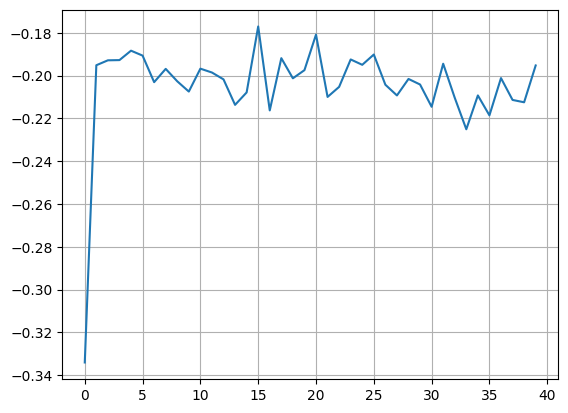

In [52]:
q_dict = dict()
results = []
for k in trange(40):
    policy = create_greedy_policy(q_dict)
    res, exp = apply_policy(policy, deck, 10000, gamma=0.5, random_init_action=True, random_init_state=True)
    results.append(res.loss_per_game())
    q_dict = evaluate_Q(exp)
plt.plot(results)
plt.grid(True)

In [53]:
res, _ = apply_policy(create_greedy_policy(q_dict), deck, 10000)
print(res)

total score=-939/10000 games (-0.0939 per game) :: W 41.17% | D 8.27% | L 50.56%

In [54]:
res, _ = apply_policy(dealer_policy, deck, 10000)
print(res)

total score=-875/10000 games (-0.0875 per game) :: W 40.32% | D 10.61% | L 49.07%

It is also useful to track "validation performance" during training, and to store the policy that was shown to be best in the validation phase, and not the last computed policy!

100%|███████████████████████████████████████████| 40/40 [00:36<00:00,  1.10it/s]


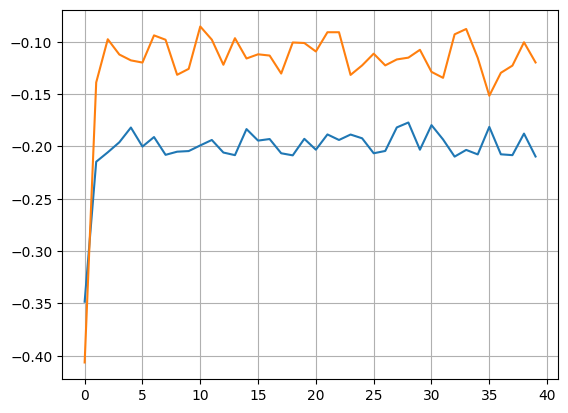

In [55]:
q_dict = dict()
results = []
results_val = []
best_val_loss = None
q_dict_best = None
for k in trange(40):
    policy = create_greedy_policy(q_dict)
    res, exp = apply_policy(policy, deck, 10000, gamma=0.5, random_init_action=True, random_init_state=True)
    res_val, _ = apply_policy(policy, deck, 10000)
    results.append(res.loss_per_game())
    results_val.append(res_val.loss_per_game())
    if not best_val_loss or best_val_loss <  res_val.loss_per_game():
        best_val_loss = res_val.loss_per_game()
        q_dict_best = deepcopy(q_dict)
    q_dict = evaluate_Q(exp)
plt.plot(results)
plt.plot(results_val)
plt.grid(True)

In [56]:
best_policy = create_greedy_policy(q_dict_best)

In [57]:
res, _ = apply_policy(best_policy, deck, 10000)
print(res)

total score=-1110/10000 games (-0.1110 per game) :: W 40.49% | D 7.92% | L 51.59%

## Visualizing the best policy

Let us now create a function which will enable us to visualize policies. The visualization will be very effective in understanding what a policy actually does!

In [58]:
def visualize_policy(policy):
    """Visualize the policy.

    The policy will be visualized using a colored greed.
    The horizontal axis will correspond to the player total and the vertical axis to the
    dealer's total.

    If a cell is colored in red, it means that the action is HIT, regardless of existence of usable ACE.
    If a cell is colored in blue, it means HOLD, regardless of existence of usable ACE.
    Green cells are those in which HIT will be played only if there is a usable ACE.
    Black cells are those in which HIT will be played only if there is no usable ACE.

    Since the last case (play HIT if there is no usable ACE, and HOLD otherwise) seems counterintutive,
    the color black is selected to distinguish it from other states.
    """
    player_values = list(range(2, 21))
    dealer_values = list(range(2, 12))
    board = np.ones(shape=(len(dealer_values), len(player_values), 3), dtype=np.uint8)
    for r, dv in enumerate(dealer_values):
        for c, pv in enumerate(player_values):
            if pv < 11:
                action_t = policy(State(pv, False, dv)) == Action.HIT
                if action_t:
                    board[r, c, :] = (255, 0, 0)
                else:
                    board[r, c, :] = (0, 0, 255)
            else:
                action_t = policy(State(pv, True, dv)) == Action.HIT
                action_f = policy(State(pv, False, dv)) == Action.HIT
                if action_t and action_f:
                    board[r, c, :] = (255, 0, 0)
                elif action_t and not action_f:
                    board[r, c, :] = (0, 255, 0)
                elif not action_t and not action_f:
                    board[r, c, :] = (0, 0, 255)
                else:
                    board[r, c, :] = (0, 0, 0)
    plt.imshow(board, extent=[2, 21, 12, 2])
    plt.xticks(np.arange(2.5, 21.5, 1), np.arange(2, 21, 1))
    plt.yticks(np.arange(2.5, 12.5, 1), np.arange(2, 12, 1))
    plt.xlabel("player total")
    plt.ylabel("dealer total")

As expected, the dealer policy is very simple and clear!

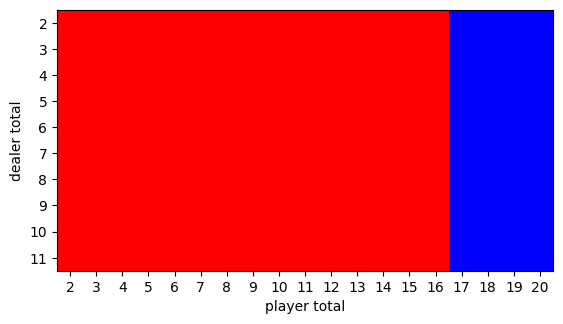

In [59]:
visualize_policy(dealer_policy)

The random policy is very random :) Important thing to understand is that the image below will differ each time the line of code is invoked, because each time the policy will randomly choose one of the two possible actions for each state.

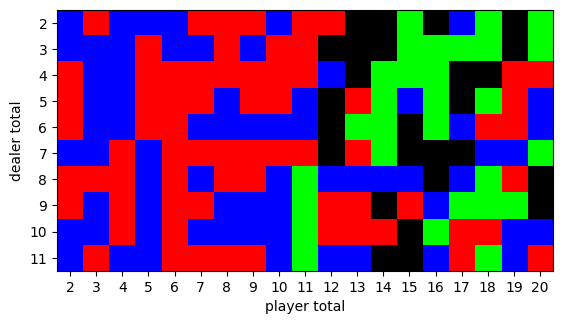

In [60]:
visualize_policy(random_policy)

Notice that there are no black or green fields for player total less than 11. In these cases, it is impossible for a player to have a usable ACE, so that a level of randomness is reduced.

What about our "best policy" (which we hope to be nearly optimal)?

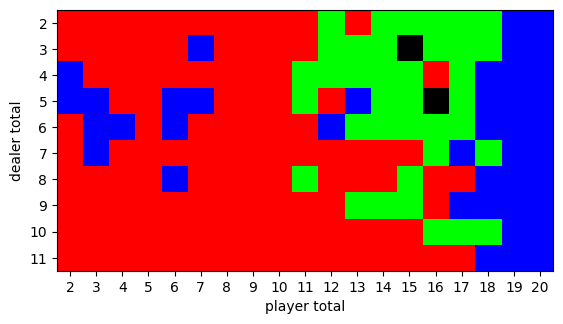

In [61]:
visualize_policy(best_policy)

Well, the black fields should not be there. Also the green islands in the seas of red (and vice versa) are also suspicious if present. The policy seems reasonable, but it also seems too erratic. Compare this visualization with the simplicity of the dealer's policy. We need to do better. **We need to train better...** 

## Incremental Learning

A **big problem** with _"naive"_ Monte Carlo approaches, as the one used until now is that -- as soon as we collect new experience and update the policy -- we essentially discard and forget all that has been learned before. All previous experience is essentially wasted, and we are hoping that each inter-update epoch will be rich enough.

What we would like instead is that we accumulate new knowledge along the way and to update our existing assesments of the Q-values. In order to do so, let us first implement a function that updates an existing estimate of a state-action value given a new gain value attained starting from the given state and applying the given initial action.

In [62]:
def update_q_value(current: float, target: float, alpha: float) -> float:
    """Update the given current estimate given the new target.
    
    Args:
        current (float): existing estimate
        target (float): the given target
        alpha (float): learning rate

    Return:
        float: the new, updated estimate
    """
    if current is not None and target is not None:
        return current + alpha * (target - current)
    elif current is None:
        return target
    elif target is None:
        return current
    else:
        return None

Now, we can implement a function that will update the entire `q_dict`, given the a new experience.

In [63]:
def update_Q(q_dict: QDict, experience: Experience, alpha=0.1):
    """Update Q-function based on the given experience."""
    gains_dict = create_gains_dict(experience)

    for s, (gains_HIT, gains_HOLD) in gains_dict.items():
        target_value_HIT = np.mean(gains_HIT) if gains_HIT else None
        target_value_HOLD = np.mean(gains_HOLD) if gains_HOLD else None
        old_value_HIT, old_value_HOLD = q_dict.get(s, (None, None))
        q_value_HIT = update_q_value(old_value_HIT, target_value_HIT, alpha)
        q_value_HOLD = update_q_value(old_value_HOLD, target_value_HOLD, alpha)
        q_dict[s] = (q_value_HIT, q_value_HOLD)

    return q_dict

Now, we are finally in position to re-write the learning loop in an incremental form...

100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


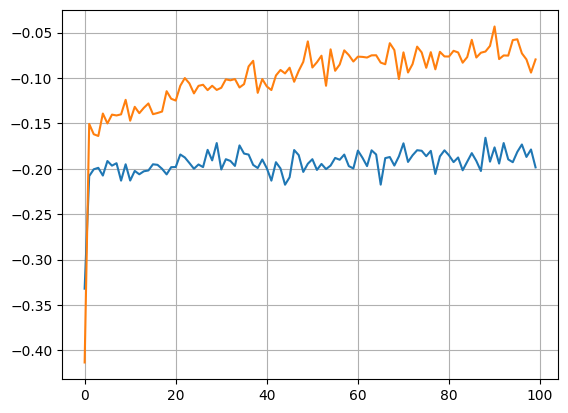

In [64]:
q_dict = dict()
results = []
results_val = []
best_val_loss = None
q_dict_best = None
alpha = 0.02
for k in trange(100):
    policy = create_greedy_policy(q_dict)
    res, exp = apply_policy(policy, deck, 10000, gamma=0.5, random_init_action=True, random_init_state=True)
    res_val, _ = apply_policy(policy, deck, 10000)
    results.append(res.loss_per_game())
    results_val.append(res_val.loss_per_game())
    if not best_val_loss or best_val_loss <  res_val.loss_per_game():
        best_val_loss = res_val.loss_per_game()
        q_dict_best = deepcopy(q_dict)
    update_Q(q_dict, exp, alpha)
plt.plot(results)
plt.plot(results_val)
plt.grid(True)

We use more iterations because we can now reuse the previous knowledge, so it does not seem wastefull to use more iterations. Let us test and visualize the policy again...

In [65]:
best_policy = create_greedy_policy(q_dict_best)

In [66]:
res, _ = apply_policy(best_policy, deck, 10000)
print(res)

total score=-640/10000 games (-0.0640 per game) :: W 42.42% | D 8.76% | L 48.82%

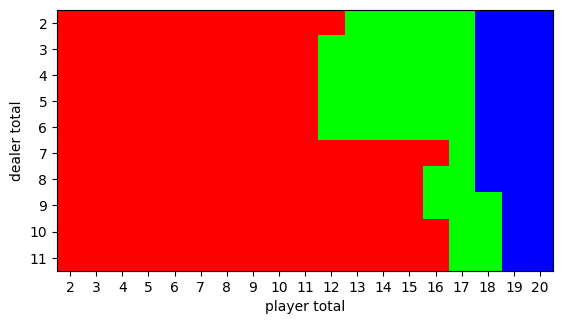

In [67]:
visualize_policy(best_policy)

This is much more reasonable! Perhaps we can do a bit better by concentrating all our learning efforts to the narrow streak of the state-space in which there is still some ambiguity. This, however, is left to the reader for further excercise.

**Notice that this policy outperforms the policy of the dealer, but still results in loss of money!**

## Assignments for Individual Work

### Level 1

Repeat the functionality of this notebook using more realistic Blackjack rules. For example, in the actual game of Blackjack each player immediately gets two cards (however, only one of the dealer's cards is known to the player, before the player finishes his/hers turn).

### Level 2

Make the dealer a learning agent also. Repeat the functionality of this notebook (leave the rules the same) by making the dealer's strategy learnable. Train both the player and the dealer by making them play againsta one another (adversarial learning). What is the optimal policy of the dealer? How does it compare to the current one?

### Level 3

Make the game symmetric in the following way: Instead of the Player and the Dealer, let us talk about Player 1 and Player 2. 

Each game consists of two rounds, in the first round Player 1 plays first and in the second round Player 2 plays first. 

Each round is a single game of blackjack with one card handled to each player and one common card drawn (so that each player forms the initial sum from two cards, with one card being shared by both players). Each player plays (chooses HIT or HOLD) in each turn. If one of the players becomes busted, or if one of the player chooses HOLD, the other player continues drawing cards until he/she is also busted or chooses HOLD. At the end, the player with highest sum less than 21 wins the round.

Upon completion of the round, each player receives +1, 0, or -1, depending on the outcome. The total outgome of one game is the sum of outcomes of the two rounds.

## Project for Individual Work

Implement the game in its more realistic form: with betting and other allowed actions besides HIT and HOLD. For the actual rules, see https://en.wikipedia.org/wiki/Blackjack